In [1]:
#将球管测试集和训练集分别合并，产生了测试集和训练集的比例，列长为10477
import pandas as pd 

from sklearn.model_selection import train_test_split


all_xiaoqiu=pd.read_csv('dataset/qiuguan/orign/xiaoqiu/train_val_info.csv',sep=',')
all_xiaoqiu=all_xiaoqiu.iloc[:,1:]

all_xiaoguan=pd.read_csv('dataset/qiuguan/orign/xiaoguan/train_val_info.csv',sep=',')
all_xiaoguan=all_xiaoguan.iloc[:,1:]
#print(all)

all=pd.concat([all_xiaoguan,all_xiaoqiu],axis=0)
print(all)


test_xiaoqiu=pd.read_csv('dataset/qiuguan/orign/xiaoqiu/test_info.csv',sep=',')
test_xiaoqiu=test_xiaoqiu.iloc[:,1:]


test_xiaoguan=pd.read_csv('dataset/qiuguan/orign/xiaoguan/test_info.csv',sep=',')
test_xiaoguan=test_xiaoguan.iloc[:,1:]
#print(all)

test=pd.concat([test_xiaoguan,test_xiaoqiu],axis=0)
print(test)



all.to_csv('dataset/qiuguan/orign/xiaoqiu_xiaoguan/train_val_info.csv')
test.to_csv('dataset/qiuguan/orign/xiaoqiu_xiaoguan/test_info.csv')

         A1CF        A2M    A4GALT     A4GNT      AAAS      AACS     AADAC  \
0    6.431258  11.248749  5.349804  5.120827  6.798356  7.275802  5.612603   
1    9.158275  10.253835  5.325083  4.699884  6.899807  7.014170  4.826159   
2    9.431977  10.279957  5.623591  4.909059  6.892876  7.085651  4.921009   
3    8.310742  10.212451  5.258408  4.648383  7.145988  7.269771  4.882796   
4    8.787169  10.410063  5.878387  4.822982  6.986281  7.268022  4.804635   
..        ...        ...       ...       ...       ...       ...       ...   
273  7.276473  13.954133  6.321114  5.416700  7.975881  8.763367  5.086040   
274  6.318789  13.317725  6.298130  5.161601  8.260172  8.779150  5.162641   
275  7.212215  13.105286  6.636644  5.476388  8.460173  8.573436  5.557923   
276  5.938221  13.034388  6.187187  5.201022  8.098349  9.154647  4.831131   
277  6.278951  13.447125  6.629170  5.324371  8.342648  8.396911  5.002872   

        AAGAB      AAK1     AAMDC  ...    ZSWIM8      ZW10    Z

In [5]:
import torch
import Trainer
from network import NFM
import torch.utils.data as Data
from Utils.criteo_loader import getTestData, getTrainData

nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,9],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}

#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(10477)
        self.fc1 = nn.Linear(10477, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
print(model)


import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
import config
import evaluate
import data_utils
#import Trainer



def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output

class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
        '''
        txt_path: 所有数据的路径，我的形式为(单张图片路径 类别\n)
        img1.png 0
        ...
         img100.png 1
         ki：当前是第几折,从0开始，范围为[0, K)
         K：总的折数
         typ：用于区分训练集与验证集
         transform：对图片的数据增强
         rand：是否随机
        '''
        '''
        self.all_data_info = self.get_img_info(txt_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        '''
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    '''
    @staticmethod
    def get_img_info(txt_path):
        # 解析输入的txt的函数
        # 转为二维list存储，每一维为 [ 图片路径，图片类别]
        data_info = []
        data = open(txt_path, 'r')
        data_lines = data.readlines()
        for data_line in data_lines:
            data_line = data_line.split()
            img_pth = data_line[0]
            label = int(data_line[1])
            data_info.append((img_pth, label))
        return data_info
    
    '''
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',',header=None)
        df=df.iloc[1:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        #print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision


        

class KZDataset(Dataset):
    def __init__(self, csv_path, K,n_class,ki=0, typ='train', transform=None, rand=False):
        '''
        txt_path: 所有数据的路径，我的形式为(单张图片路径 类别\n)
        img1.png 0
        ...
         img100.png 1
         ki：当前是第几折,从0开始，范围为[0, K)
         K：总的折数
         typ：用于区分训练集与验证集
         transform：对图片的数据增强
         rand：是否随机
        '''
        '''
        self.all_data_info = self.get_img_info(txt_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        '''
        self.all_data_info = self.get_data_info(csv_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    '''
    @staticmethod
    def get_img_info(txt_path):
        # 解析输入的txt的函数
        # 转为二维list存储，每一维为 [ 图片路径，图片类别]
        data_info = []
        data = open(txt_path, 'r')
        data_lines = data.readlines()
        for data_line in data_lines:
            data_line = data_line.split()
            img_pth = data_line[0]
            label = int(data_line[1])
            data_info.append((img_pth, label))
        return data_info
    
    '''
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',',header=None)
        df=df.iloc[1:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        #print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            '''
            if i==62:
                for num,i in enumerate(data):
                    print(num,i)
            data=[eval(i) for i in data]
            
            #data=data.values
            #data=data.applymap(ast.literal_eval)
            #data=data.applymap(ast.literal_eval)
            #data=eval(data)
            #print("i:",i)
            
            
            #print(data)
            
            label=[]
            print(df.iloc[i,-1])
            label.append(eval(df.iloc[i,-1]))
            print("label:",i,label)
            #label=[eval(i) for i in label]
            
            #label=label.applymap(ast.literal_eval)
            
            #print(label)
            label=one_hot_smoothing(np.array(label),nfm_config['n_class'])
            label=label.tolist()
            
            '''
            
            data_info.append((data,label))
        return data_info
            
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import sys 
#import network
import config
import evaluate
import data_utils
import Trainer
import torchmetrics

from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import sys 
#import network
import config
import evaluate
import data_utils
import Trainer
import torchmetrics


def train_epoch(model,train_loader,batch_size,optimizer,loss_func):
    BATCH_SIZE=batch_size
    total = 0
    correct=0
    total_loss=0
    #
    model.train()
    total_train_accuracy=0  
    for batch_idx, (x, labels) in enumerate(train_loader):
            
        labels = Variable(labels)
        x = Variable(x)
            
            
        x=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(labels,dtype=torch.float)
        x, labels = x.cuda(), labels.cuda()
        labels_int=labels=torch.max(labels,1)[1]
            
            
        optimizer.zero_grad()
        y_predict = model(x)
            
        loss = loss_func(y_predict, labels)
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
           

        total_loss += loss
            
            
            
        batch_train_acc=torchmetrics.functional.accuracy(y_predict,labels_int)
        total_train_accuracy+=batch_train_acc
            
    total_train_accuracy/=(batch_idx+1)
    print('total_train_accuracy:',total_train_accuracy)
    print("Training Epoch: %d, total loss: %f" % (epoch_id, total_loss))
    return total_loss,total_train_accuracy

def val_epoch(model,test_loader,batch_size,optimizer): 
    batch_size_num=0
    total_test_acc=0
    model.eval()
    for i , (inputs , targets) in enumerate(test_loader):   
            print("test")
            
            inputs = Variable(inputs)   
            targets = Variable(targets)     
           
            inputs=torch.tensor(inputs ,dtype=torch.float)   
            targets=torch.tensor(targets ,dtype=torch.float)   
            inputs , targets = inputs.cuda(),  targets.cuda()   
            yhat = model(inputs)  
            
            
            
            targets=torch.max(targets,1)[1]
            
            
            
            batch_test_acc=torchmetrics.functional.accuracy(yhat,targets)
            
            total_test_acc+=batch_test_acc
            
            batch_size_num=i
    total_test_acc/=(batch_size_num+1)
        ###print('total_test_accuracy:',total_test_acc/(batch_size+1))
    print('total_test_accuracy:',total_test_acc)
        
                    
                    
            
            
    
        
   
    
    return total_test_acc


import numpy as np
import math
import matplotlib.pyplot as plt

def plotLoss(loss,epoch):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    x=[i for i in range(epoch)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(x, loss, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
 



MLP(
  (bn0): BatchNorm1d(10477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10477, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


/home/zhengfang/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:447: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:448: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total_train_accuracy: tensor(0.1375, device='cuda:0')
Training Epoch: 0, total loss: 65.750614
total_train_accuracy: tensor(0.1813, device='cuda:0')
Training Epoch: 1, total loss: 65.034235
total_train_accuracy: tensor(0.2083, device='cuda:0')
Training Epoch: 2, total loss: 64.812834
total_train_accuracy: tensor(0.2792, device='cuda:0')
Training Epoch: 3, total loss: 63.998621
total_train_accuracy: tensor(0.2688, device='cuda:0')
Training Epoch: 4, total loss: 63.729160
total_train_accuracy: tensor(0.3458, device='cuda:0')
Training Epoch: 5, total loss: 62.861712
total_train_accuracy: tensor(0.3583, device='cuda:0')
Training Epoch: 6, total loss: 62.309847
total_train_accuracy: tensor(0.3771, device='cuda:0')
Training Epoch: 7, total loss: 62.054175
total_train_accuracy: tensor(0.4021, device='cuda:0')
Training Epoch: 8, total loss: 61.255363
total_train_accuracy: tensor(0.4104, device='cuda:0')
Training Epoch: 9, total loss: 61.490319
total_train_accuracy: tensor(0.3979, device='cuda:

total_train_accuracy: tensor(0.8688, device='cuda:0')
Training Epoch: 86, total loss: 47.211011
total_train_accuracy: tensor(0.9250, device='cuda:0')
Training Epoch: 87, total loss: 45.903132
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 88, total loss: 46.817666
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 89, total loss: 46.527468
total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 90, total loss: 46.055551
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 91, total loss: 46.413690
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 92, total loss: 46.937184
total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 93, total loss: 46.012346
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 94, total loss: 45.634076
total_train_accuracy: tensor(0.9146, device='cuda:0')
Training Epoch: 95, total loss: 46.367677
total_train_accuracy: tensor(0.9000, dev

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


the  0  epoch ends


/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)


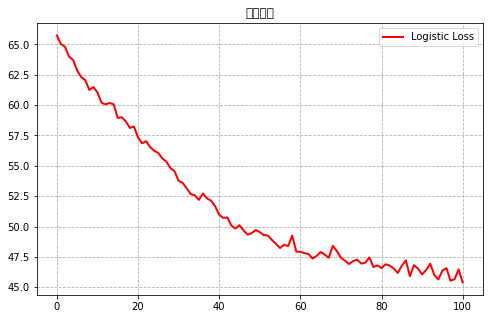

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:485: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test
test
test
total_test_accuracy: tensor(0.8125, device='cuda:0')
acc_test_each_k: tensor(0.8125, device='cuda:0')
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 0, total loss: 46.711634
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 1, total loss: 46.184328
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 2, total loss: 45.313099
total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 3, total loss: 45.966095
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 4, total loss: 45.949409
total_train_accuracy: tensor(0.9271, device='cuda:0')
Training Epoch: 5, total loss: 45.407923
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 6, total loss: 45.006853
total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 7, total loss: 45.059830
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 8, total loss: 45.211986
total_train_accuracy: tensor

total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 85, total loss: 43.601681
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 86, total loss: 44.006187
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 87, total loss: 43.377707
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 88, total loss: 43.234483
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 89, total loss: 43.700606
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 90, total loss: 43.577169
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 91, total loss: 43.618098
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 92, total loss: 43.788623
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 93, total loss: 43.862750
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 94, total loss: 44.539522
total_train_accuracy: tensor(0.9521, dev

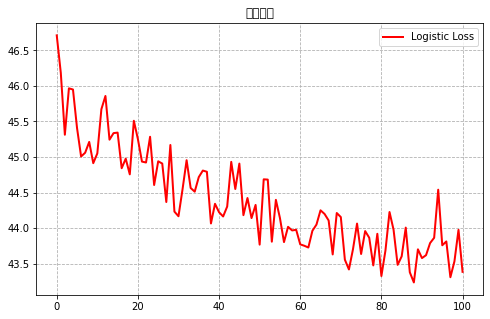

test
test
test
total_test_accuracy: tensor(0.9375, device='cuda:0')
acc_test_each_k: tensor(0.9375, device='cuda:0')
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 0, total loss: 44.070100
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 1, total loss: 43.958951
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 2, total loss: 43.743465
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 3, total loss: 43.509456
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 4, total loss: 43.439712
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 5, total loss: 42.970818
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 6, total loss: 43.281273
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 7, total loss: 43.462132
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 8, total loss: 43.511619
total_train_accuracy: tensor

total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 85, total loss: 42.956167
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 86, total loss: 42.822502
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 87, total loss: 42.676242
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 88, total loss: 43.224506
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 89, total loss: 43.488767
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 90, total loss: 42.678761
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 91, total loss: 42.799839
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 42.635273
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 93, total loss: 42.557575
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 94, total loss: 42.742187
total_train_accuracy: tensor(0.9750, dev

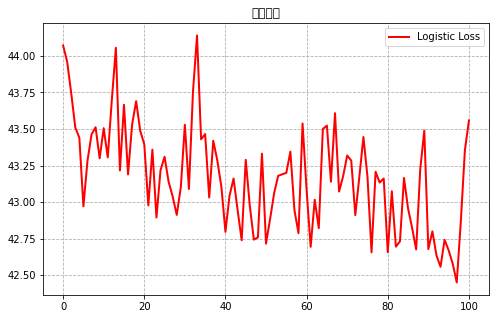

test
test
test
total_test_accuracy: tensor(0.8958, device='cuda:0')
acc_test_each_k: tensor(0.8958, device='cuda:0')
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 0, total loss: 43.030158
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 1, total loss: 43.341200
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 2, total loss: 42.917825
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 3, total loss: 42.684990
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 4, total loss: 42.831253
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 42.532408
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 6, total loss: 42.875248
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 7, total loss: 43.147595
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 8, total loss: 42.928258
total_train_accuracy: tensor

total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 85, total loss: 42.222095
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 86, total loss: 42.745528
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 87, total loss: 42.540276
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 88, total loss: 42.805360
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 89, total loss: 42.810223
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 90, total loss: 42.446998
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 91, total loss: 42.958963
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 92, total loss: 42.509560
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.555361
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 94, total loss: 42.537796
total_train_accuracy: tensor(0.9729, dev

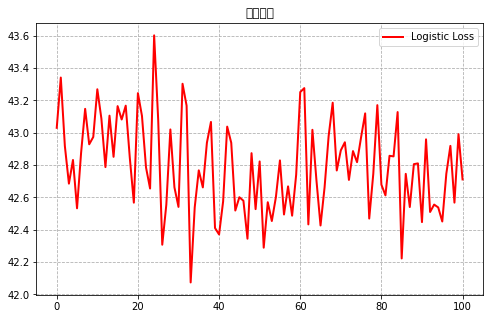

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.561956
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 1, total loss: 42.643660
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 2, total loss: 42.475288
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 3, total loss: 42.474797
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 4, total loss: 42.288417
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 5, total loss: 42.508854
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 6, total loss: 42.419578
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.721739
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 8, total loss: 42.282051
total_train_accuracy: tensor

total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 85, total loss: 42.361950
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 86, total loss: 42.108339
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 87, total loss: 42.402357
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 88, total loss: 42.153710
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 89, total loss: 42.362645
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 90, total loss: 42.702365
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 91, total loss: 42.636920
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 92, total loss: 42.298942
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 93, total loss: 42.225657
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 94, total loss: 41.842454
total_train_accuracy: tensor(0.9854, dev

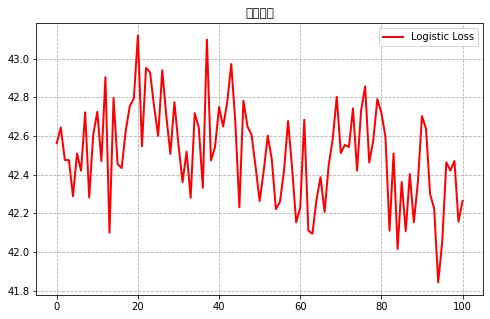

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 0, total loss: 42.550283
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 1, total loss: 42.471339
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 2, total loss: 42.511833
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 3, total loss: 42.437970
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 4, total loss: 42.884038
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 5, total loss: 42.464025
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 6, total loss: 42.459262
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.751828
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 42.802598
total_train_accuracy: tensor

total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 85, total loss: 42.473686
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 86, total loss: 42.392982
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 87, total loss: 42.313545
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 42.065895
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 89, total loss: 42.442711
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 90, total loss: 42.521539
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 91, total loss: 42.434313
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 92, total loss: 42.247417
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.354365
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.536108
total_train_accuracy: tensor(0.9688, dev

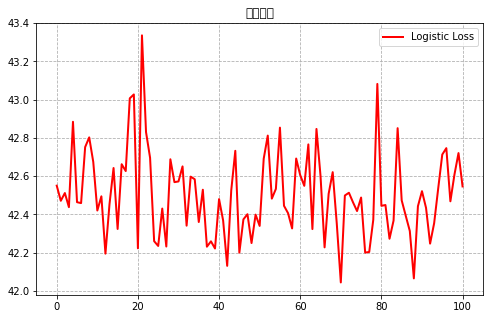

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 0, total loss: 42.237262
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 1, total loss: 42.522050
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 2, total loss: 42.495892
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 3, total loss: 42.504878
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 4, total loss: 42.582826
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 42.186589
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 6, total loss: 42.511367
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 7, total loss: 43.255797
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 8, total loss: 42.501565
total_train_accuracy: tensor(0.9688,

total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 85, total loss: 42.114011
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 86, total loss: 42.122461
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 87, total loss: 42.190254
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 88, total loss: 41.995796
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.293972
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 90, total loss: 42.660122
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 91, total loss: 42.431954
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 92, total loss: 42.421090
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 93, total loss: 42.617863
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 42.186350
total_train_accuracy: tensor(0.9792, dev

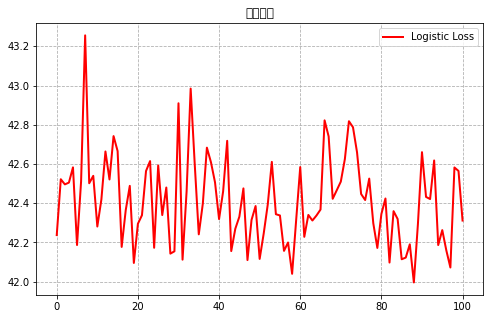

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 0, total loss: 42.439314
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 1, total loss: 42.514575
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 2, total loss: 42.366884
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 3, total loss: 42.305524
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 4, total loss: 42.359970
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 5, total loss: 42.346305
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 6, total loss: 42.179000
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 7, total loss: 42.283148
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 8, total loss: 42.221077
total_train_accuracy: tensor(0.9750,

total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 85, total loss: 42.460085
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.363040
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 87, total loss: 41.973252
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 42.155399
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 89, total loss: 42.369938
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 90, total loss: 42.090498
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 91, total loss: 42.193929
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 92, total loss: 42.207108
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.469404
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 94, total loss: 42.522214
total_train_accuracy: tensor(0.9792, dev

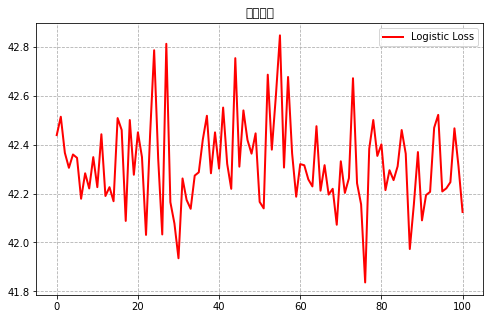

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 0, total loss: 42.561125
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 1, total loss: 43.052078
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 2, total loss: 42.514460
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 3, total loss: 42.117982
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 4, total loss: 42.570751
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 5, total loss: 42.566301
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 6, total loss: 42.257030
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 7, total loss: 42.048939
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 42.527854
total_train_accuracy: tensor(0.9729,

total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 85, total loss: 42.541793
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 86, total loss: 42.421571
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 87, total loss: 42.452037
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 88, total loss: 42.293986
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 89, total loss: 41.806721
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 41.871895
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 91, total loss: 42.296956
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 92, total loss: 42.295498
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 93, total loss: 41.949474
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.475656
total_train_accuracy: tensor(0.9833, dev

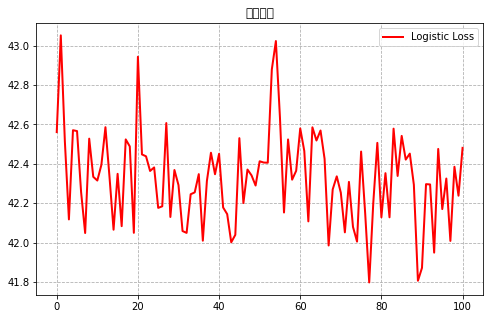

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.366975
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 1, total loss: 42.427969
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 2, total loss: 42.581179
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 3, total loss: 42.271601
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 4, total loss: 41.967013
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 42.262288
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 6, total loss: 42.010263
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 7, total loss: 42.241967
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 8, total loss: 42.395345
total_train_accuracy: tensor(0.9792,

total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 85, total loss: 41.864249
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 86, total loss: 42.263201
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 87, total loss: 42.231760
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 88, total loss: 42.346015
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 89, total loss: 42.036940
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 90, total loss: 41.948804
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 91, total loss: 42.419611
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 92, total loss: 41.980821
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 93, total loss: 42.131950
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 94, total loss: 42.452143
total_train_accuracy: tensor(0.9729, dev

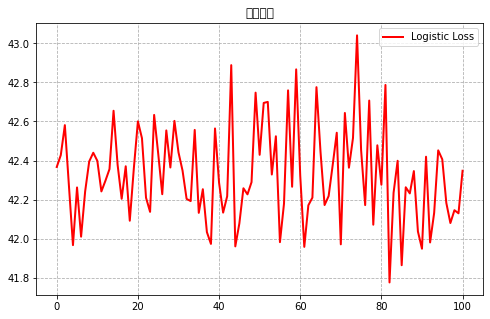

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
[tensor(0.8125, device='cuda:0'), tensor(0.9375, device='cuda:0'), tensor(0.8958, device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[array(0.8125, dtype=float32), array(0.9375, dtype=float32), array(0.8958334, dtype=float32), array(0.9583334, dtype=float32), array(0.9583334, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]
acc_test_metrics: 0.95625


In [6]:
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/MLP_non_encode/'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)

MLP(
  (bn0): BatchNorm1d(10477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10477, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


/home/zhengfang/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

f1_score:  %.4f 0.8543492304497252
accuracy_score: 0.8405797101449275
recall_score: 0.8429593717829013
pre_recall: 0.8790666123999458
n_classes: 9


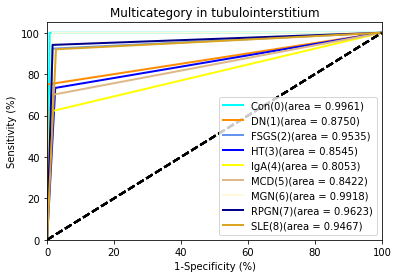

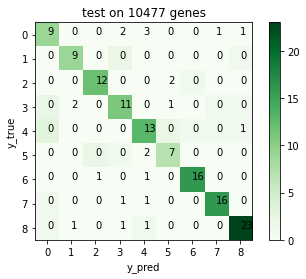

In [8]:
import torch

#功能：加载保存到path中的各层参数到神经网络

path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/MLP_non_encode/MLP610.pkl'

#nfm=NFM(nfm_config)
mlp=MLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    plt.title('Multicategory in tubulointerstitium') 
      

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 



#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 10477 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()

MLP(
  (bn0): BatchNorm1d(10477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10477, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


/home/zhengfang/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

f1_score:  %.4f 0.9599857583973885
accuracy_score: 0.9428571428571428
recall_score: 0.954405162738496
pre_recall: 0.9703703703703704
n_classes: 9


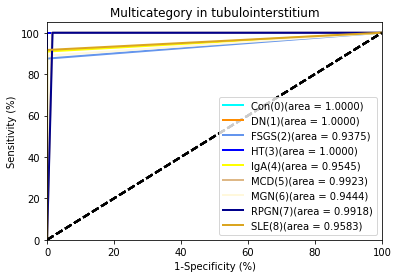

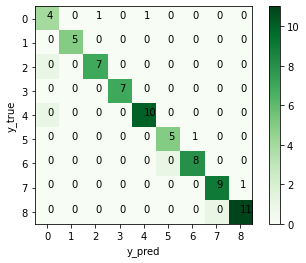

In [3]:
import torch

#功能：加载保存到path中的各层参数到神经网络

path='dataset/qiuguan/orign/xiaoqiu_xiaoguan/MLP_non_encode/MLP610.pkl'

#nfm=NFM(nfm_config)
mlp=MLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/orign/xiaoqiu/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    plt.title('Multicategory in tubulointerstitium') 
      

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 



#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()